Ready!

OBJECT CROPPING SYSTEM
Upload images:



Saving img 3.jpg to img 3 (1).jpg

[1/1] img 3 (1).jpg
--------------------------------------------------
✓ Face detected


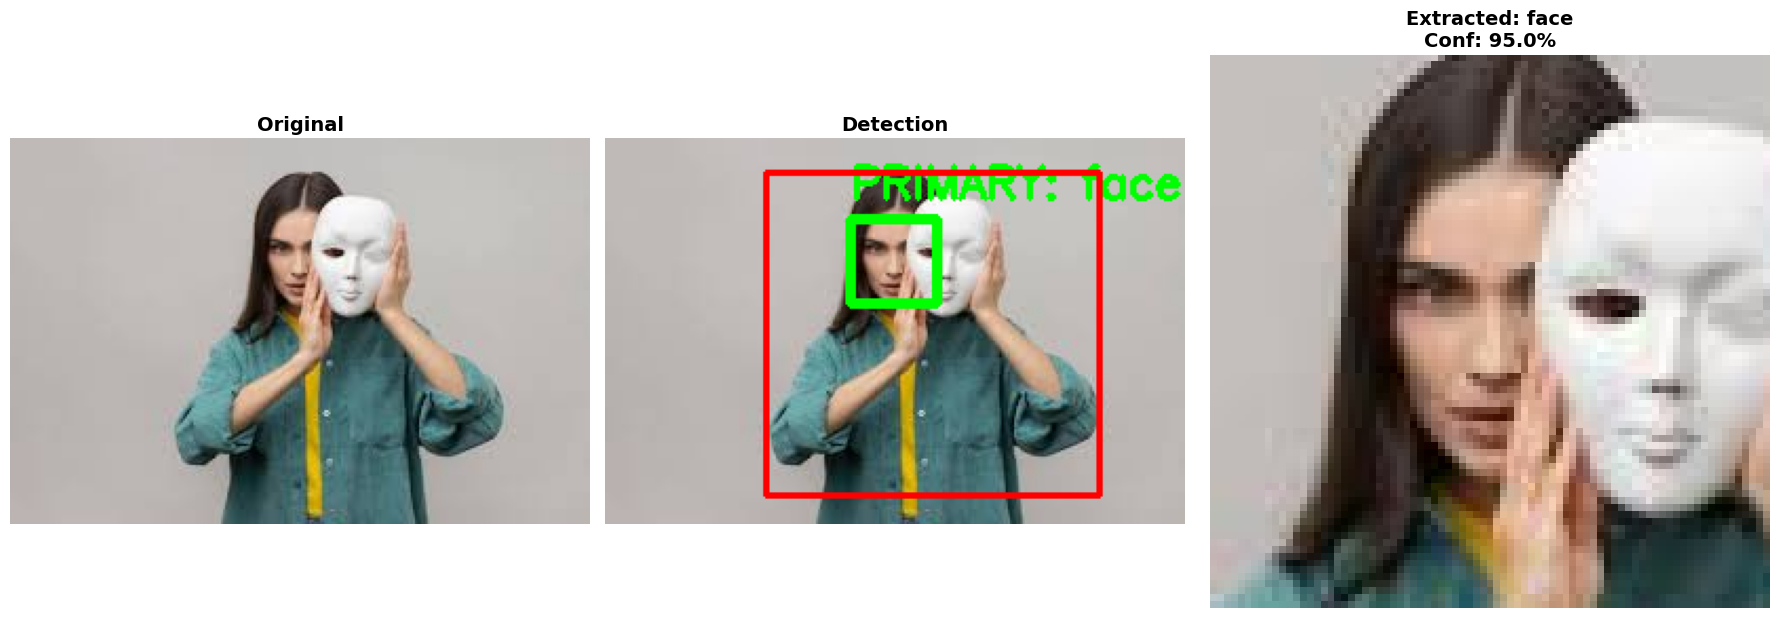

Saved: results/cropped_img 3 (1).jpg

Done! Check 'results' folder

💡 Run again for more images


In [2]:
# Overlapping Object Cropping Project

!pip install ultralytics opencv-python-headless matplotlib mediapipe -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import mediapipe as mp
from google.colab import files
import os

# Load models
model = YOLO('yolov8n-seg.pt')
face_detector = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
print("Ready!\n")


def detect_face(img):
    """Find face in image"""
    result = face_detector.process(img)
    if not result.detections:
        return None

    box = result.detections[0].location_data.relative_bounding_box
    h, w = img.shape[:2]

    x1 = max(0, int(box.xmin * w))
    y1 = max(0, int(box.ymin * h))
    x2 = min(w, int((box.xmin + box.width) * w))
    y2 = min(h, int((box.ymin + box.height) * h))

    return (x1, y1, x2, y2)


def process_image(path):
    """Main processing function"""
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    padding = 20

    # Try face detection first
    face_box = detect_face(img)
    detections = model(img, verbose=False)

    if face_box:
        print("✓ Face detected")
        x1, y1, x2, y2 = face_box
        x1, y1 = max(0, x1-padding), max(0, y1-padding)
        x2, y2 = min(w, x2+padding), min(h, y2+padding)
        cropped = img[y1:y2, x1:x2]
        show_result(img, face_box, cropped, detections, "face", 0.95, True)
        return cropped

    # Fallback to YOLO
    if len(detections[0].boxes) == 0:
        print("No objects found")
        return img

    print(f"Found {len(detections[0].boxes)} objects")

    # Find best object using scoring
    best_idx = 0
    best_score = -1

    for i, box in enumerate(detections[0].boxes):
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        cls = int(box.cls[0].cpu().numpy())
        name = detections[0].names[cls]

        # Score based on size, confidence, center position, and type
        area_score = ((x2-x1)*(y2-y1)) / (h*w)
        center_x, center_y = (x1+x2)/2, (y1+y2)/2
        dist = np.sqrt((center_x-w/2)**2 + (center_y-h/2)**2)
        center_score = 1 - (dist / np.sqrt((w/2)**2 + (h/2)**2))
        type_score = {'person':10, 'cat':8, 'dog':8, 'face':15}.get(name, 5) / 15.0

        score = area_score*0.25 + conf*0.25 + center_score*0.15 + type_score*0.35

        if score > best_score:
            best_score = score
            best_idx = i

    # Crop best object
    box = detections[0].boxes[best_idx]
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
    conf = box.conf[0].cpu().numpy()
    cls = int(box.cls[0].cpu().numpy())
    name = detections[0].names[cls]

    print(f"✓ Selected: {name}")

    x1, y1 = max(0, x1-padding), max(0, y1-padding)
    x2, y2 = min(w, x2+padding), min(h, y2+padding)
    cropped = img[y1:y2, x1:x2]

    # Apply mask if available
    if detections[0].masks is not None:
        mask = detections[0].masks.data[best_idx].cpu().numpy()
        mask = cv2.resize(mask, (w, h))[y1:y2, x1:x2]
        mask_3d = np.stack([mask]*3, axis=-1)
        cropped = np.where(mask_3d > 0.5, (cropped*mask_3d).astype(np.uint8),
                          np.ones_like(cropped)*255).astype(np.uint8)

    show_result(img, None, cropped, detections, name, conf, False, best_idx)
    return cropped


def show_result(img, face_box, cropped, detections, name, conf, is_face, idx=0):
    """Visualize results"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    ax1.imshow(img)
    ax1.set_title("Original", fontsize=14, weight='bold')
    ax1.axis('off')

    # Draw boxes
    img_box = img.copy()

    if is_face and face_box:
        x1, y1, x2, y2 = face_box
        cv2.rectangle(img_box, (x1,y1), (x2,y2), (0,255,0), 3)
        cv2.putText(img_box, "PRIMARY: face", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        for box in detections[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            cv2.rectangle(img_box, (x1,y1), (x2,y2), (255,0,0), 2)
    else:
        for i, box in enumerate(detections[0].boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            cls = int(box.cls[0].cpu().numpy())
            n = detections[0].names[cls]
            color = (0,255,0) if i==idx else (255,0,0)
            thick = 3 if i==idx else 2
            cv2.rectangle(img_box, (x1,y1), (x2,y2), color, thick)
            cv2.putText(img_box, f"PRIMARY: {n}" if i==idx else n, (x1,y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    ax2.imshow(img_box)
    ax2.set_title("Detection", fontsize=14, weight='bold')
    ax2.axis('off')

    ax3.imshow(cropped)
    ax3.set_title(f"Extracted: {name}\nConf: {conf:.1%}", fontsize=14, weight='bold')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()


# Run
print("="*50)
print("OBJECT CROPPING SYSTEM")
print("="*50)
print("Upload images:\n")

uploaded = files.upload()

if uploaded:
    os.makedirs('results', exist_ok=True)

    for i, filename in enumerate(uploaded.keys()):
        print(f"\n[{i+1}/{len(uploaded)}] {filename}")
        print("-"*50)

        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

        result = process_image(filename)

        output = f"results/cropped_{filename}"
        cv2.imwrite(output, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        print(f"Saved: {output}\n")

    print("="*50)
    print("Done! Check 'results' folder")
    print("="*50)

print("\n💡 Run again for more images")